In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

#Get bitcoin market info: "Date", "Open", "High", "Low", "Close", "Volume", "Market Cap".
bitcoin_market_info = pd.read_csv("Bitcoin-data.csv")
bitcoin_market_info['Date'] = pd.to_datetime(bitcoin_market_info.Date)
bitcoin_market_info.sort_values(by='Date', inplace=True, ascending=True)
bitcoin_market_info = bitcoin_market_info.set_index('Date')

# Convert"Volume" to an integer.
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')

# Look at the first few rows.
bitcoin_market_info.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2015-01-01,320.43,320.43,314.00,314.25,8036550,"4,297,535,768"
2015-01-02,314.08,315.84,313.57,315.03,7860650,"4,309,551,126"
2015-01-03,314.85,315.15,281.08,281.08,33054400,"3,846,269,872"
2015-01-04,281.15,287.23,257.61,264.20,55629100,"3,616,320,975"
2015-01-05,265.08,278.34,265.08,274.47,43962800,"3,758,098,008"


In [3]:
bitcoin_market_info['Volume'].dtype

dtype('int64')

In [2]:
bitcoin_market_info.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'], dtype='object')

In [3]:
bitcoin_market_info.drop(['Volume','Market Cap'],axis=1,inplace=True)

In [4]:
#Only keep columns "Open", "High", "Low", "Close".
bitcoin_market_info

,Open,High,Low,Close
Date,,,,
2015-01-01,320.43,320.43,314.00,314.25
2015-01-02,314.08,315.84,313.57,315.03
2015-01-03,314.85,315.15,281.08,281.08
2015-01-04,281.15,287.23,257.61,264.20
2015-01-05,265.08,278.34,265.08,274.47
...,...,...,...,...
2020-03-27,6719.39,6793.84,6466.70,6469.80
2020-03-28,6467.25,6467.50,6117.84,6242.19
2020-03-29,6245.62,6250.47,5920.09,5922.04


In [5]:
#Check if any NAN values remain in the dataset
bitcoin_market_info.isnull().any()

Open     False
High     False
Low      False
Close    False
dtype: bool

In [6]:
#Shape of the dataset
bitcoin_market_info.shape

(1917, 4)

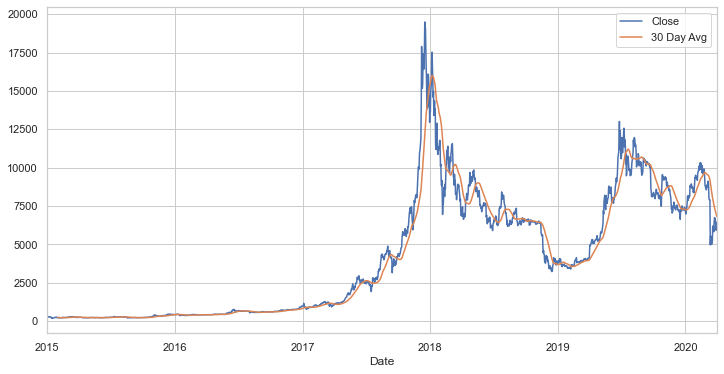

In [7]:
#Plotting the bitcoin_data on graph using seaborn

sns.set()
sns.set_style('whitegrid')

bitcoin_market_info = bitcoin_market_info.astype(float)

bitcoin_market_info['Close'].plot(figsize=(12,6), label='Close')

#Plotting the rolling 30 day average against the Close Price
bitcoin_market_info['Close'].rolling(window=30).mean().plot(label='30 Day Avg')
plt.legend()

In [8]:
#Calculating the OHLC Average of data for each day

btc = bitcoin_market_info
btc['OHLC_Average'] = (btc['Open'] + btc['High'] + btc['Low'] + btc['Close']) / 4

In [9]:
btc.head()

,Open,High,Low,Close,OHLC_Average
Date,,,,,
2015-01-01,320.43,320.43,314.00,314.25,317.2775
2015-01-02,314.08,315.84,313.57,315.03,314.6300
2015-01-03,314.85,315.15,281.08,281.08,298.0400
2015-01-04,281.15,287.23,257.61,264.20,272.5475
2015-01-05,265.08,278.34,265.08,274.47,270.7425


In [10]:
btc['Price_After_Month']=btc['Close'].shift(-30)

In [11]:
btc.tail()

,Open,High,Low,Close,OHLC_Average,Price_After_Month
Date,,,,,,
2020-03-27,6719.39,6793.84,6466.70,6469.80,6612.4325,NaN
2020-03-28,6467.25,6467.50,6117.84,6242.19,6323.6950,NaN
2020-03-29,6245.62,6250.47,5920.09,5922.04,6084.5550,NaN
2020-03-30,5925.54,6517.20,5903.23,6429.84,6193.9525,NaN
2020-03-31,6430.61,6504.52,6374.16,6438.64,6436.9825,NaN


In [12]:
from sklearn import preprocessing

btc.dropna(inplace=True)
X=btc.drop('Price_After_Month',axis=1)

#We need to scale our values to input them in our model
X=preprocessing.scale(X)
y=btc['Price_After_Month']

In [13]:
from sklearn import model_selection
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.3,random_state=101)

In [14]:
from sklearn.ensemble import RandomForestRegressor
reg=RandomForestRegressor(n_estimators=200,random_state=101)
reg.fit(X_train,y_train)
accuracy=reg.score(X_test,y_test)
accuracy=accuracy*100
accuracy = float("{0:.4f}".format(accuracy))

In [15]:
#This percentage shows how much our regression fits our data
print('Accuracy is:',accuracy,'%')

Accuracy is: 87.041 %


In [16]:
preds = reg.predict(X_test)

#We can see that our predictions are kind of accurate.
print("Prediction:", preds[1], "\nReal Value:", y_test[1])

Prediction: 654.4334999999978 
Real Value: 632.83


In [17]:
#Apply our model and get our prediction
#Take the last 30 elements to make our predictions on them

X_30=X[-30:]
forecast=reg.predict(X_30)

In [18]:
#Creating a new column which contains the predictions

from datetime import datetime, timedelta
last_date=btc.iloc[-1].name
modified_date = last_date + timedelta(days=1)
date=pd.date_range(modified_date,periods=30,freq='D')
df1=pd.DataFrame(forecast,columns=['Forecast'],index=date)
btc=btc.append(df1)

In [19]:
btc.tail(15)

,Open,High,Low,Close,OHLC_Average,Price_After_Month,Forecast
2020-03-17,NaN,NaN,NaN,NaN,NaN,NaN,6518.19040
2020-03-18,NaN,NaN,NaN,NaN,NaN,NaN,6258.21335
2020-03-19,NaN,NaN,NaN,NaN,NaN,NaN,7102.74575
2020-03-20,NaN,NaN,NaN,NaN,NaN,NaN,6835.91975
2020-03-21,NaN,NaN,NaN,NaN,NaN,NaN,7834.97165
2020-03-22,NaN,NaN,NaN,NaN,NaN,NaN,6421.46800
2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN,6489.13310
2020-03-24,NaN,NaN,NaN,NaN,NaN,NaN,7707.91640
2020-03-25,NaN,NaN,NaN,NaN,NaN,NaN,6863.88770
2020-03-26,NaN,NaN,NaN,NaN,NaN,NaN,7075.21535


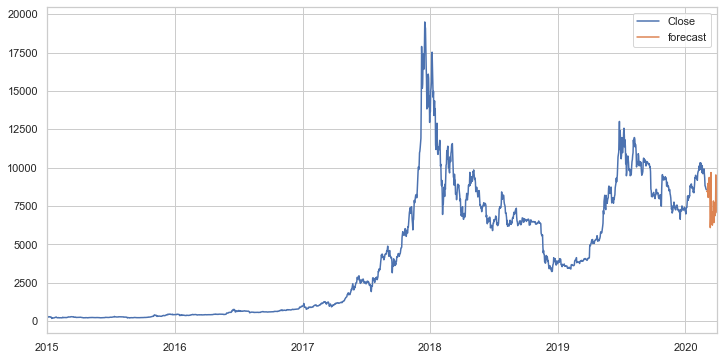

In [20]:
#Predictions plotted on the chart

btc['Close'].plot(figsize=(12,6),label='Close')
btc['Forecast'].plot(label='forecast')
plt.legend()

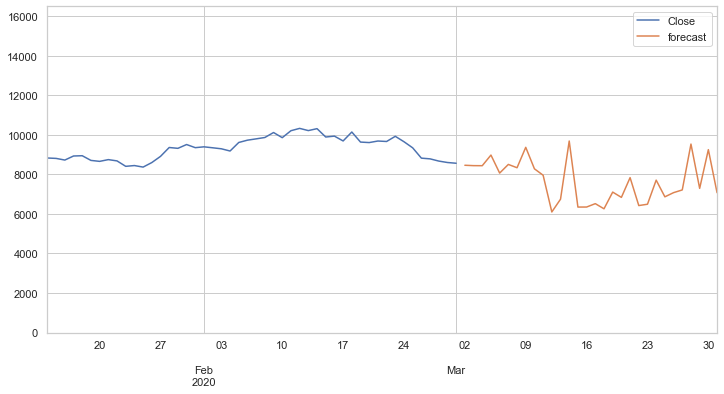

In [21]:
#Predictions plotted on the chart (Magnified)

btc['Close'].plot(figsize=(12,6),label='Close')
btc['Forecast'].plot(label='forecast')
plt.axis((18275, 18352, 0, 16500))
plt.legend()

In [22]:
from sklearn import metrics

M1 = metrics.mean_absolute_error(y_test, preds);
M2 = metrics.mean_squared_error(y_test, preds);
M3 = np.sqrt(metrics.mean_squared_error(y_test, preds));

print('Mean Absolute Error:', M1)
print('Mean Squared Error:', M2)
print('Root Mean Squared Error:', M3)

Mean Absolute Error: 709.9670030864198
Mean Squared Error: 1992595.680432776
Root Mean Squared Error: 1411.5933126905836
